In [24]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
# Load the data
df = pd.read_csv('data/all_weights.csv')

# Define the dependent variables
dvs = ['Effort', 'Helpfulness', 'Trustworthy']

In [26]:
df_boxcox = df.copy()

# Apply Box-Cox transformation
for dv in dvs:
    df_boxcox[dv], _ = stats.boxcox(df[dv])

In [27]:

# Check original scales
for dv in ['Effort', 'Helpfulness', 'Trustworthy']:
    print(f"{dv} original range: {df[dv].min():.2f} to {df[dv].max():.2f}")

# Check transformed scales
for dv in ['Effort', 'Helpfulness', 'Trustworthy']:
    print(f"{dv} transformed range: {df_boxcox[dv].min():.2f} to {df_boxcox[dv].max():.2f}")

# Check lambda values
for dv in ['Effort', 'Helpfulness', 'Trustworthy']:
    _, lambda_value = stats.boxcox(df[dv])
    print(f"Lambda for {dv}: {lambda_value:.4f}")

# Check skewness before and after transformation
for dv in ['Effort', 'Helpfulness', 'Trustworthy']:
    original_skew = stats.skew(df[dv])
    transformed_skew = stats.skew(df_boxcox[dv])
    print(f"{dv} original skewness: {original_skew:.4f}")
    print(f"{dv} transformed skewness: {transformed_skew:.4f}")
    print()

Effort original range: 3.16 to 22.09
Helpfulness original range: 2.57 to 18.02
Trustworthy original range: 4.38 to 20.63
Effort transformed range: 1.22 to 3.68
Helpfulness transformed range: 11.87 to 38262.81
Trustworthy transformed range: 10.58 to 305.86
Lambda for Effort: 0.1082
Lambda for Helpfulness: 4.1409
Lambda for Trustworthy: 2.1433
Effort original skewness: 0.7528
Effort transformed skewness: -0.0152

Helpfulness original skewness: -2.0222
Helpfulness transformed skewness: -0.5205

Trustworthy original skewness: -0.7283
Trustworthy transformed skewness: -0.2358



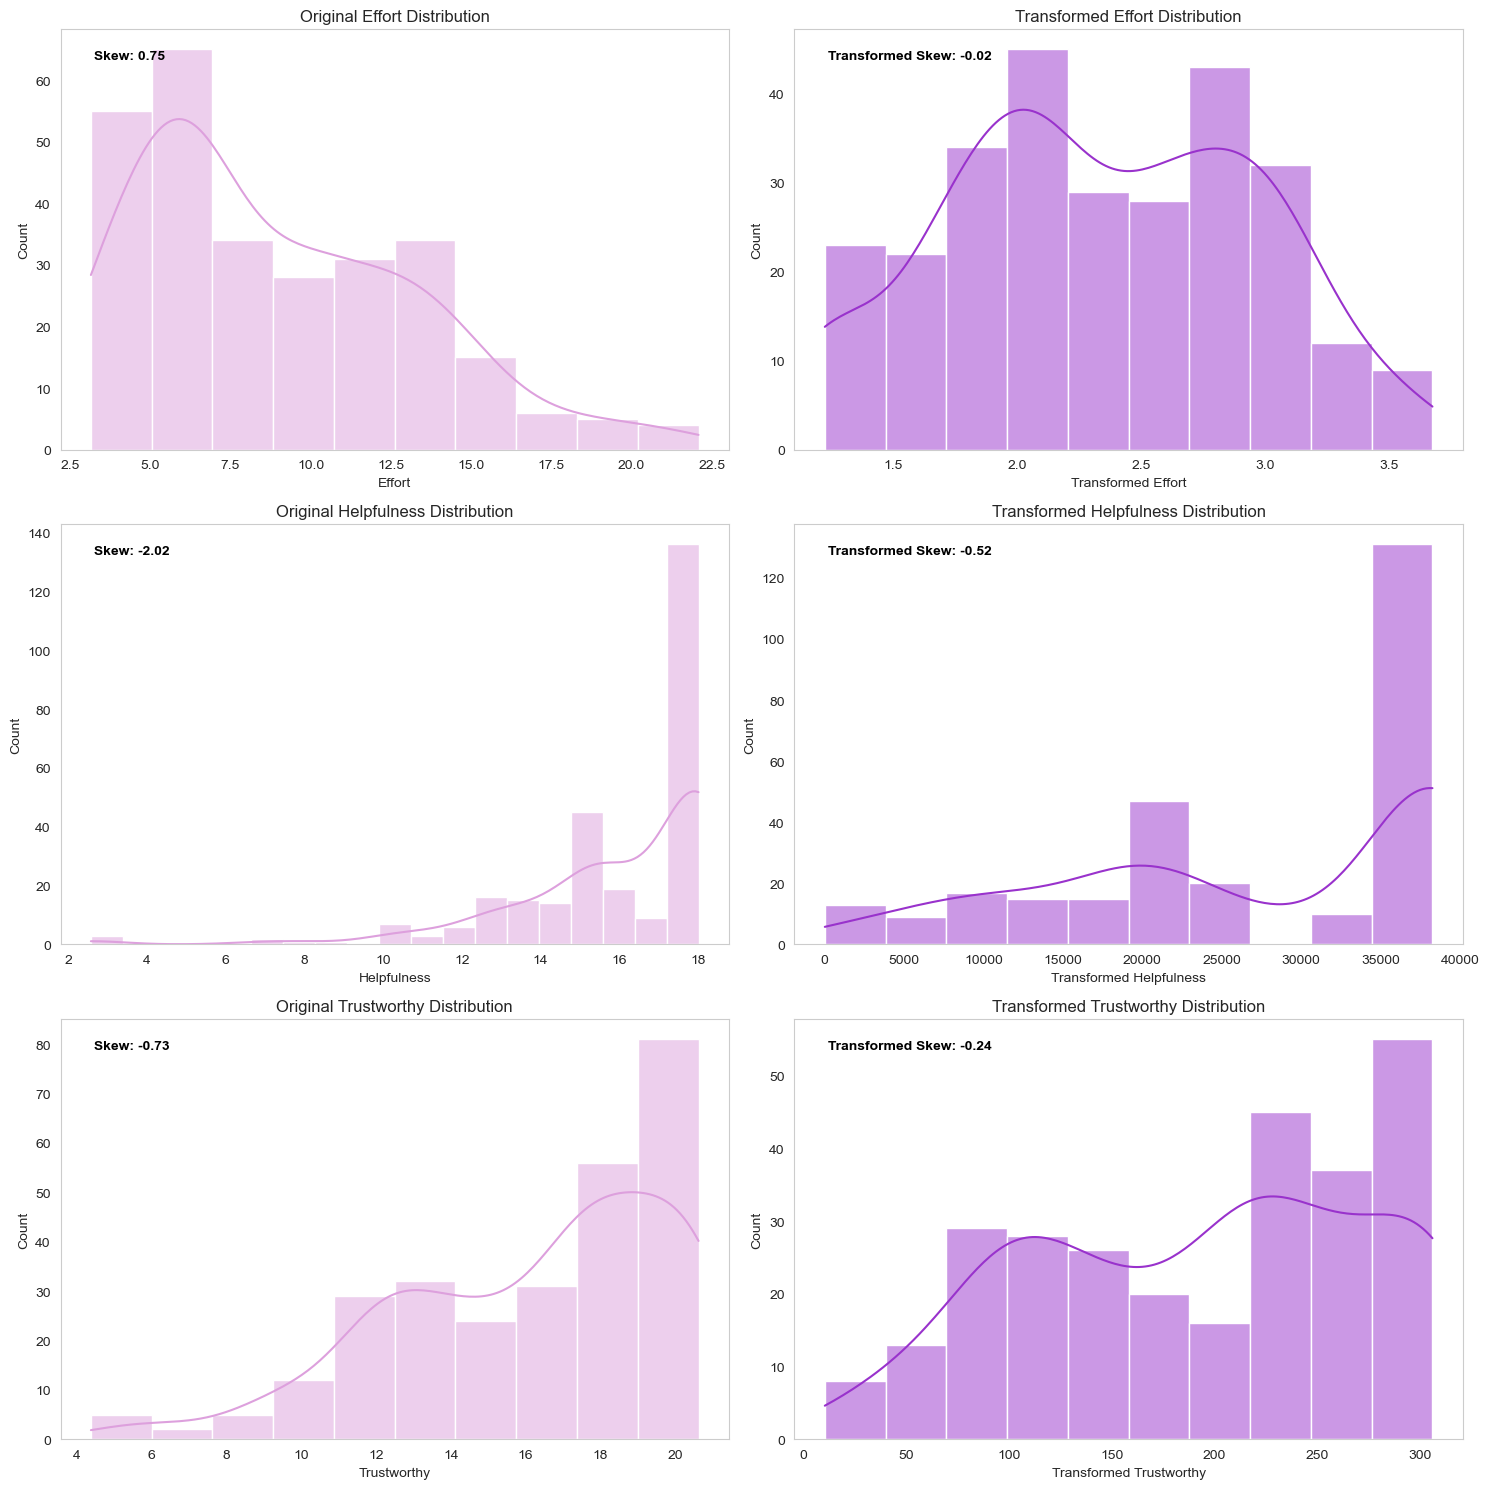

In [28]:
plt.figure(figsize=(15,15))
for i, dv in enumerate(['Effort', 'Helpfulness', 'Trustworthy']):
    plt.subplot(3, 2, 2*i+1)
    sns.histplot(df[dv], kde=True, color='plum')
    plt.title(f'Original {dv} Distribution')
    plt.xlabel(dv)
    original_skew = stats.skew(df[dv])
    plt.text(0.05, 0.95, f'Skew: {original_skew:.2f}', transform=plt.gca().transAxes, 
            verticalalignment='top', color='black', fontweight='bold')
    
    plt.subplot(3, 2, 2*i+2)
    sns.histplot(df_boxcox[dv], kde=True, color='darkorchid')
    plt.title(f'Transformed {dv} Distribution')
    plt.xlabel(f'Transformed {dv}')
    transformed_skew = stats.skew(df_boxcox[dv])
    plt.text(0.05, 0.95, f'Transformed Skew: {transformed_skew:.2f}', transform=plt.gca().transAxes, 
            verticalalignment='top', color='black', fontweight='bold')

plt.tight_layout()
plt.show()


In [29]:
# 1. Full model
df_full = df_boxcox.copy()
df_full['EmpathyBot'] = df_full['EmpathyBot'].replace({'FAQ': 0, 'Empathy': 2, 'NonEmpathy': 1})

# 2. FAQ vs Non-empathy model
df_faq_non = df_boxcox[df_boxcox['EmpathyBot'].isin(['FAQ', 'NonEmpathy'])].copy()
df_faq_non['EmpathyBot'] = df_faq_non['EmpathyBot'].replace({'FAQ': 0, 'NonEmpathy': 1})

# 3. Empathy vs Non-empathy model
df_emp_non = df_boxcox[df_boxcox['EmpathyBot'].isin(['Empathy', 'NonEmpathy'])].copy()
df_emp_non['EmpathyBot'] = df_emp_non['EmpathyBot'].replace({'Empathy': 0, 'NonEmpathy': 1})



In [30]:
# df_full = df.copy()

# df_faq_non = df[df['EmpathyBot'].isin(['FAQ', 'NonEmpathy'])].copy()

# df_emp_non = df[df['EmpathyBot'].isin(['Empathy', 'NonEmpathy'])].copy()


In [31]:
def create_interaction_plot(df, dv, x, hue, x_order):
    plt.figure(figsize=(6, 6)) 
    sns.set_style("whitegrid", {'axes.grid' : False})  # Remove background grid
    
    # Use the specified colors and markers
    colors = ['darkorchid', 'plum']
    markers = ['D', '^']
    
    ax = sns.lineplot(data=df, x=x, y=dv, hue=hue, style=hue,
                    palette=colors, markers=markers, dashes=False,
                    markersize=10, linewidth=2, err_style='bars', errorbar=('ci', 30),
                    hue_order=['No', 'Yes'], style_order=['No', 'Yes'])
    
    # Set the order of x-axis categories
    ax.set_xticks(range(len(x_order)))
    ax.set_xticklabels(x_order)
    
    # Calculate means and standard deviations for each group
    grouped = df.groupby([x, hue])
    for (x_val, hue_val), group in grouped:
        mean = group[dv].mean()
        std = group[dv].std()
        ax.annotate(f'{mean:.2f}±{std:.2f}', 
                    xy=(x_val, mean), 
                    xytext=(0, 10), 
                    textcoords='offset points',
                    ha='center', va='bottom',
                    fontsize=12, fontweight='bold')  # Make annotations bold
    if dv == 'Effort':
        dv_text  = 'Cognitive Effort'
    elif dv == 'Helpfulness':
        dv_text = 'Perceived Helpfulness'
    elif dv == 'Trustworthy':
        dv_text = 'Perceived Trustworthiness'
    else:
        dv_text = dv
    plt.ylabel(dv_text, fontsize=12, fontweight='bold')  # Bold y-label
    plt.xlabel('Communication System', fontsize=12, fontweight='bold')  # Bold x-label
    # Customize legend
    plt.legend(title=hue, fontsize=10, title_fontsize=12, frameon=True, 
            edgecolor='black', fancybox=False)
    
    # Add a subtle border around the plot
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    plt.show()

In [32]:
# Create interaction plots for each model and DV
models = {
    'FAQ vs Chatbot': df_faq_non,
    'Empathy vs Non-Empathy': df_emp_non,
    'Full Model': df_full
}

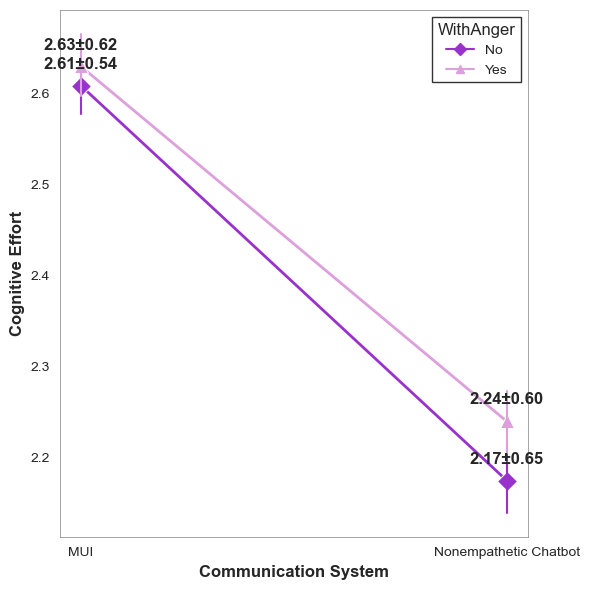

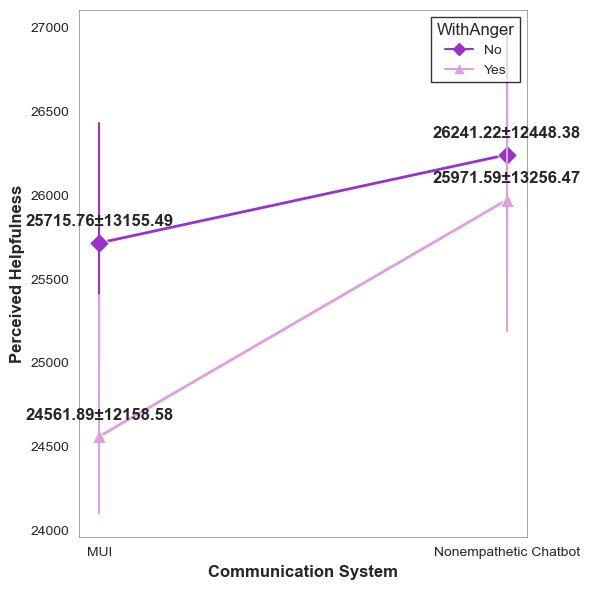

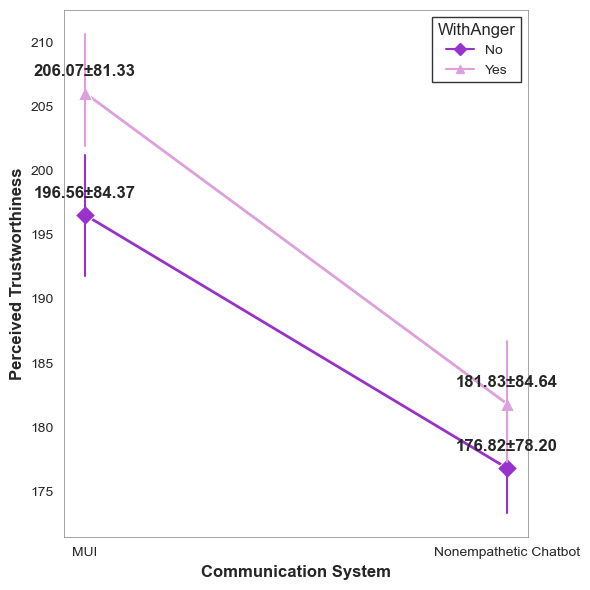

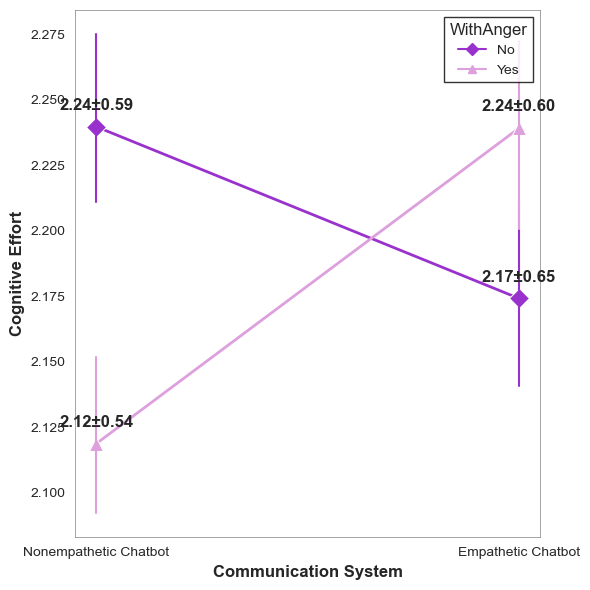

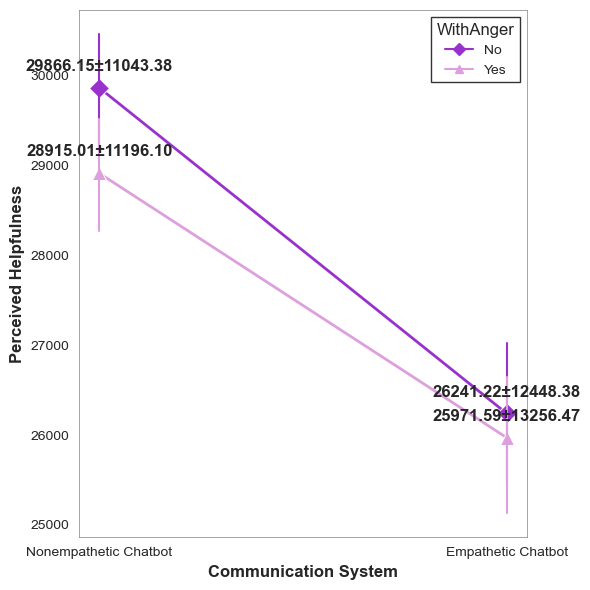

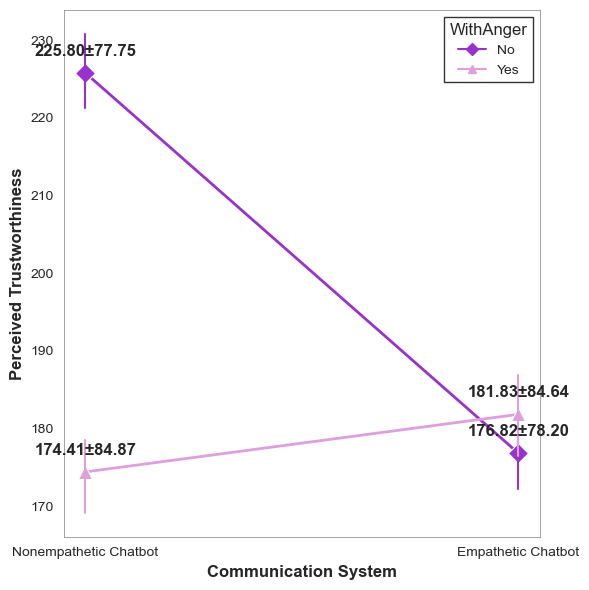

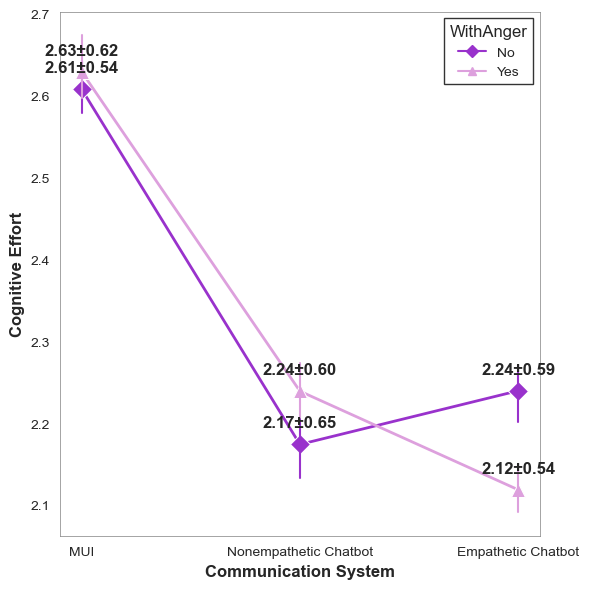

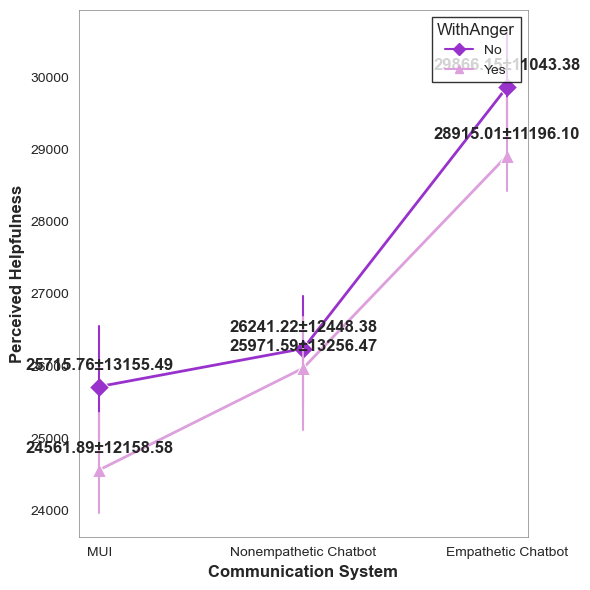

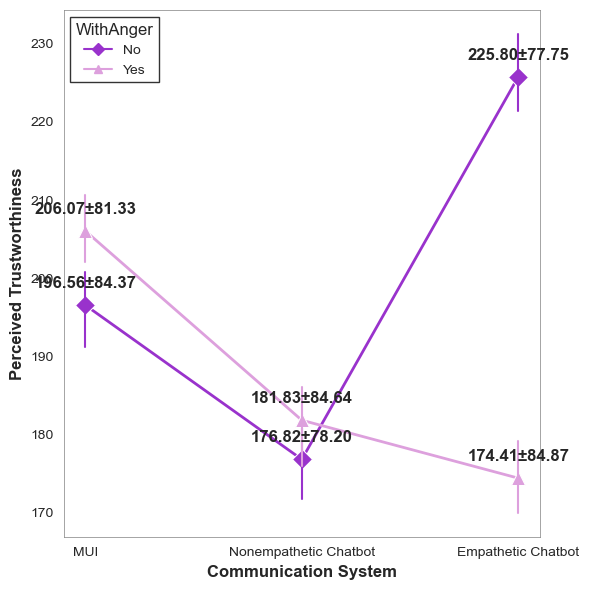

In [33]:
# Use the function for each model
for model_name, df in models.items():
    for dv in dvs:
        df_plot = models[model_name].copy()
        # Adjust x-axis labels based on the model
        if model_name == 'FAQ vs Chatbot':
            x_order = ['MUI', 'Nonempathetic Chatbot']
        elif model_name == 'Empathy vs Non-Empathy':
            x_order = ['Nonempathetic Chatbot', 'Empathetic Chatbot']
        else:  # Full Model
            x_order = ['MUI', 'Nonempathetic Chatbot', 'Empathetic Chatbot']
        
        create_interaction_plot(df_plot, dv, 'EmpathyBot', 'WithAnger', 
                                x_order=x_order)